<button onclick="var c=document.querySelectorAll('.input'); 
c.forEach(ci => ci.style.display = (ci.style.display=='none'?'':'none'));">
Hide/Show Code
</button>

# EnergyPlus Simulation Results Analysis

This notebook analyzes the results from the `Facade_CFS_VB` EnergyPlus simulation.

It focuses on:
- Time series of key thermal and environmental variables
- Energy use profiles and monthly breakdowns
- Comfort assessment
- Façade / blind state behaviour and its relation to solar conditions and loads


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches

from pathlib import Path

# Matplotlib settings
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.grid'] = True

data_path = Path('.')  # assume CSV is in the same folder as notebook
csv_file = data_path / 'External_classic.csv'

# Choose which shading system this CSV represents.
# Options:
#   'venetian'         -> multi-state venetian blinds (indices 10–15)
#   'external_classic' -> external rolling blind (6=open, 7=closed)
#   'internal_metallic'-> internal metallic blind (10=open, 11=closed)

shading_system_type = 'external_classic'  # change to 'external_classic' or 'internal_metallic' as needed

## 1. Load simulation results and parse time

EnergyPlus exports the `Date/Time` column as a string without year information.
Here we convert it to a proper `datetime` index (assuming year 2025) and create useful temporal features.


In [2]:
# Load CSV
df = pd.read_csv(csv_file)

print("Columns available (first 20):")
print(df.columns[:20])

# Robust parser for EnergyPlus Date/Time strings
# Handles:
# - Format like '01/01  00:10:00' or '12/31  24:00:00'
# - Month/Day order: MM/DD
def parse_eplus_datetime(s, year=2025):
    s = str(s).strip()
    parts = s.split()
    if len(parts) != 2:
        # Fallback: let pandas try; if it fails, return NaT
        try:
            return pd.to_datetime(s)
        except Exception:
            return pd.NaT

    date_part, time_part = parts

    # >>> IMPORTANT: interpret as MM/DD <<<
    month_str, day_str = date_part.split('/')

    try:
        month = int(month_str)
        day = int(day_str)
    except ValueError:
        return pd.NaT

    # Base date (ignore hour for now)
    try:
        base_date = pd.Timestamp(year=year, month=month, day=day)
    except Exception:
        # If something is still weird, bail out
        return pd.NaT

    # Time part: HH:MM:SS
    hms = time_part.split(':')
    if len(hms) != 3:
        # Try generic parsing as a fallback
        try:
            return pd.to_datetime(f"{year}-{month:02d}-{day:02d} {time_part}")
        except Exception:
            return pd.NaT

    hour, minute, second = map(int, hms)

    # Handle 24:00:00 by rolling to next day
    if hour == 24:
        base_date = base_date + pd.Timedelta(days=1)
        hour = 0

    return base_date + pd.Timedelta(hours=hour, minutes=minute, seconds=second)


# Apply parser
df['datetime'] = df['Date/Time'].apply(parse_eplus_datetime)

# (Optional sanity check)
print("First 10 parsed datetimes:")
print(df[['Date/Time', 'datetime']].head(10))

# Set as index and sort
df = df.set_index('datetime').sort_index()

# Add convenience time columns
df['hour'] = df.index.hour
df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['day'] = df.index.day

print("\nDataframe shape:", df.shape)
df.head()

Columns available (first 20):
Index(['Date/Time',
       'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)',
       'Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep)',
       'Environment:Site Outdoor Air Wetbulb Temperature [C](TimeStep)',
       'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)',
       'Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)',
       'Environment:Site Solar Azimuth Angle [deg](TimeStep)',
       'Environment:Site Solar Altitude Angle [deg](TimeStep)',
       'ZONE_OFFICE_PEOPLE_1:People Occupant Count [](TimeStep)',
       'FRAME:Surface Outside Face Sunlit Area [m2](TimeStep)',
       'FRAME:Surface Outside Face Sunlit Fraction [](TimeStep)',
       'SPANDREL:Surface Outside Face Sunlit Area [m2](TimeStep)',
       'SPANDREL:Surface Outside Face Sunlit Fraction [](TimeStep)',
       'FACADE:Surface Outside Face Sunlit Area [m2](TimeStep)',
       'FACADE:Surface Outside Face Sunlit 

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Wetbulb Temperature [C](TimeStep),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Solar Azimuth Angle [deg](TimeStep),Environment:Site Solar Altitude Angle [deg](TimeStep),ZONE_OFFICE_PEOPLE_1:People Occupant Count [](TimeStep),FRAME:Surface Outside Face Sunlit Area [m2](TimeStep),...,COOL_BACK:Schedule Value [](TimeStep),COOL:Schedule Value [](TimeStep),Cooling:Electricity [J](TimeStep),Heating:Electricity [J](TimeStep),Fans:Electricity [J](TimeStep),InteriorLights:Electricity [J](TimeStep),hour,dayofyear,month,day
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:10:00,01/01 00:10:00,8.3,7.55,7.906049,0.0,0.0,22.089891,-62.708334,0.0,0.0,...,30.0,26.0,0.0,0.0,0.0,11520.0,0,1,1,1
2025-01-01 00:20:00,01/01 00:20:00,8.0,7.10,7.531628,0.0,0.0,17.173308,-63.259408,0.0,0.0,...,30.0,26.0,0.0,0.0,0.0,11520.0,0,1,1,1
2025-01-01 00:30:00,01/01 00:30:00,7.7,6.65,7.158688,0.0,0.0,12.108278,-63.674009,0.0,0.0,...,30.0,26.0,0.0,0.0,0.0,11520.0,0,1,1,1
2025-01-01 00:40:00,01/01 00:40:00,7.4,6.20,6.787233,0.0,0.0,6.932710,-63.945324,0.0,0.0,...,30.0,26.0,0.0,0.0,0.0,11520.0,0,1,1,1
2025-01-01 00:50:00,01/01 00:50:00,7.1,5.75,6.417281,0.0,0.0,1.691524,-64.068664,0.0,0.0,...,30.0,26.0,0.0,0.0,0.0,11520.0,0,1,1,1


## 2. Select key variables

We extract the most relevant outputs for comfort, energy, and façade behaviour.


In [3]:
# Helper: find columns by substring
def find_cols(substr):
    return [c for c in df.columns if substr.lower() in c.lower()]

# Temperatures
col_t_out = 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'
col_t_zone_air = 'BLOCK SHOEBOX STOREY 0:Zone Mean Air Temperature [C](TimeStep)'
col_t_zone_op = 'BLOCK SHOEBOX STOREY 0:Zone Operative Temperature [C](TimeStep)'

# Solar / façade
col_solar_env_diff = 'Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)'
col_solar_env_dir = 'Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)'
col_solar_facade = 'FACADE:Surface Outside Face Incident Solar Radiation Rate per Area [W/m2](TimeStep)'
col_solar_cos = 'FACADE:Surface Outside Face Beam Solar Incident Angle Cosine Value [](TimeStep)'
col_solar_trans = 'FACADE:Surface Window Transmitted Solar Radiation Rate [W](TimeStep)'
col_solar_alt = 'Environment:Site Solar Altitude Angle [deg](TimeStep)'
col_solar_az = 'Environment:Site Solar Azimuth Angle [deg](TimeStep)'

# Energy (J → kWh)
col_e_cool = 'Cooling:Electricity [J](TimeStep)'
col_e_heat = 'Heating:Electricity [J](TimeStep)'
col_e_fans = 'Fans:Electricity [J](TimeStep)'
col_e_lights_zone = 'ZONELIGHTS:Lights Electricity Energy [J](TimeStep)'
col_e_lights_int = 'InteriorLights:Electricity [J](TimeStep) '

# Façade / blind state index
col_facade_idx = 'FACADE:Surface Construction Index [](TimeStep)'

# Occupancy / activity schedule (if present)
col_activity = 'ACTIVITY-SCHED:Schedule Value [](TimeStep)' if 'ACTIVITY-SCHED:Schedule Value [](TimeStep)' in df.columns else None

# Convert energies from J to kWh for easier interpretation
J_to_kWh = 2.77778e-7
for c in [col_e_cool, col_e_heat, col_e_fans, col_e_lights_zone, col_e_lights_int]:
    if c in df.columns:
        df[c.replace('[J](TimeStep)', '[kWh]')] = df[c] * J_to_kWh

df.head()


,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Wetbulb Temperature [C](TimeStep),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Solar Azimuth Angle [deg](TimeStep),Environment:Site Solar Altitude Angle [deg](TimeStep),ZONE_OFFICE_PEOPLE_1:People Occupant Count [](TimeStep),FRAME:Surface Outside Face Sunlit Area [m2](TimeStep),...,Fans:Electricity [J](TimeStep),InteriorLights:Electricity [J](TimeStep),hour,dayofyear,month,day,Cooling:Electricity [kWh],Heating:Electricity [kWh],Fans:Electricity [kWh],InteriorLights:Electricity [kWh]
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:10:00,01/01 00:10:00,8.3,7.55,7.906049,0.0,0.0,22.089891,-62.708334,0.0,0.0,...,0.0,11520.0,0,1,1,1,0.0,0.0,0.0,0.0032
2025-01-01 00:20:00,01/01 00:20:00,8.0,7.10,7.531628,0.0,0.0,17.173308,-63.259408,0.0,0.0,...,0.0,11520.0,0,1,1,1,0.0,0.0,0.0,0.0032
2025-01-01 00:30:00,01/01 00:30:00,7.7,6.65,7.158688,0.0,0.0,12.108278,-63.674009,0.0,0.0,...,0.0,11520.0,0,1,1,1,0.0,0.0,0.0,0.0032
2025-01-01 00:40:00,01/01 00:40:00,7.4,6.20,6.787233,0.0,0.0,6.932710,-63.945324,0.0,0.0,...,0.0,11520.0,0,1,1,1,0.0,0.0,0.0,0.0032
2025-01-01 00:50:00,01/01 00:50:00,7.1,5.75,6.417281,0.0,0.0,1.691524,-64.068664,0.0,0.0,...,0.0,11520.0,0,1,1,1,0.0,0.0,0.0,0.0032


## 3. Global time series overview

First, we inspect the full-year behaviour of outdoor and indoor conditions.


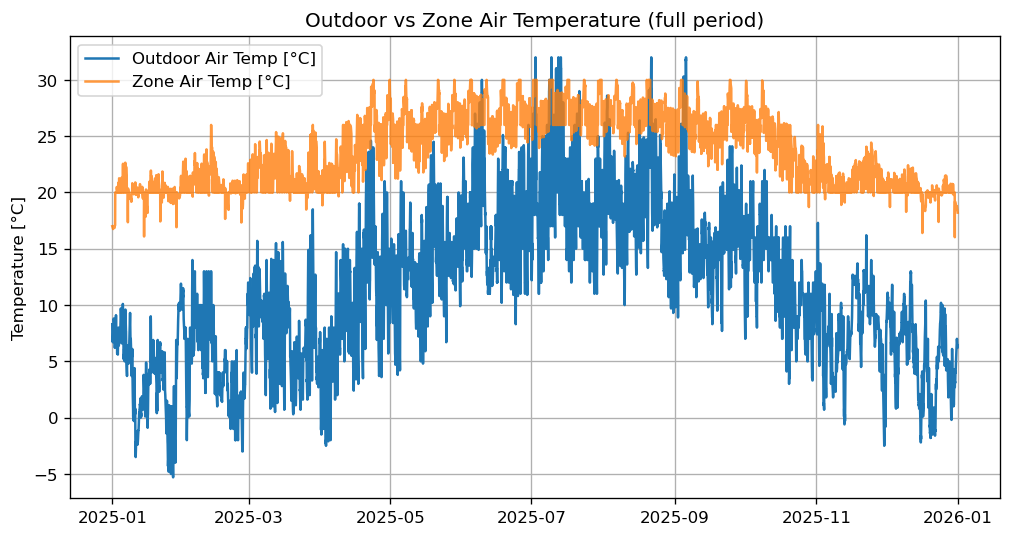

In [4]:
fig, ax = plt.subplots()
ax.plot(df.index, df[col_t_out], label='Outdoor Air Temp [°C]')
ax.plot(df.index, df[col_t_zone_air], label='Zone Air Temp [°C]', alpha=0.8)
ax.set_ylabel('Temperature [°C]')
ax.set_title('Outdoor vs Zone Air Temperature (full period)')
ax.legend()
plt.show()


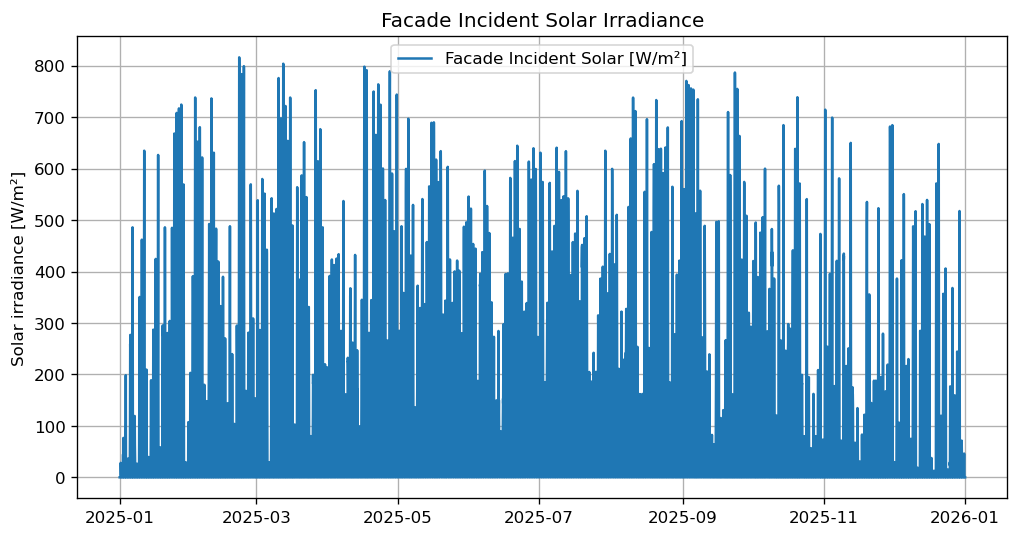

In [5]:
fig, ax = plt.subplots()
ax.plot(df.index, df[col_solar_facade], label='Facade Incident Solar [W/m²]')
ax.set_ylabel('Solar irradiance [W/m²]')
ax.set_title('Facade Incident Solar Irradiance')
ax.legend()
plt.show()


## 4. Carpet plot of the shading system state and transmitted solar radiation

Carpet plots showing the shading system state and the transmitted solar radiation for each day of the year (x-axis) and hour of the day (y-axis)


Raw façade construction index values: [6. 7.]
Mapping used: {6: 0, 7: 1}


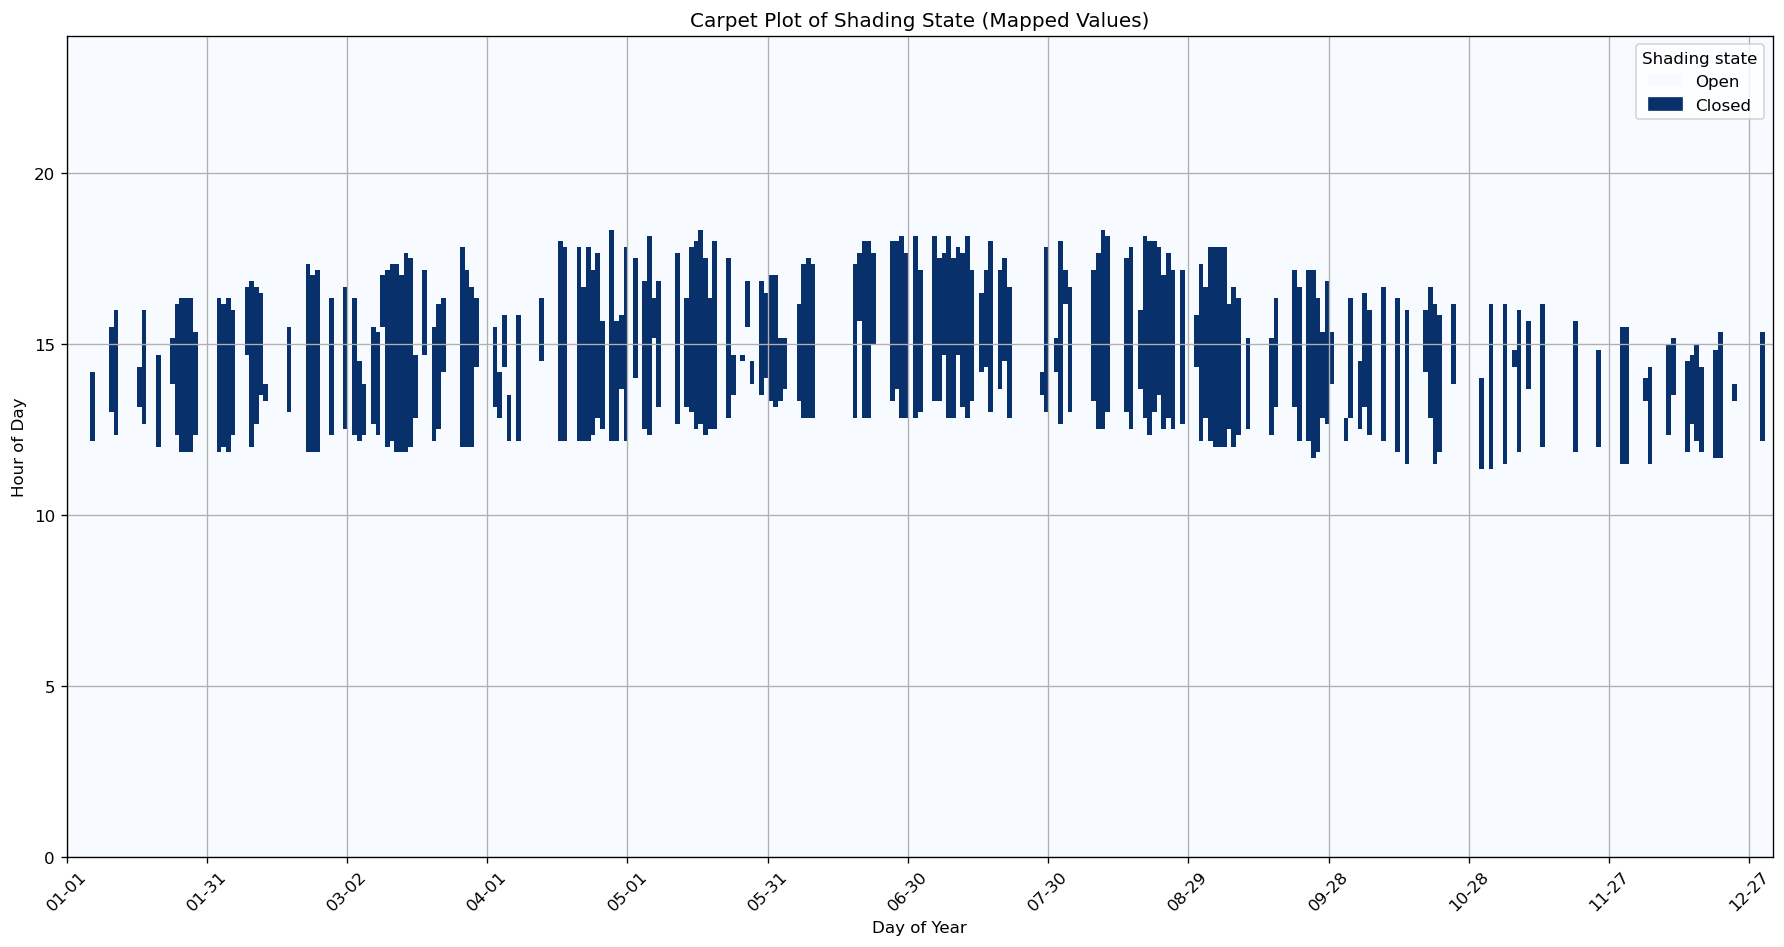

In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

col_facade = 'FACADE:Surface Construction Index [](TimeStep)'

# 1) Build DataFrame with façade construction index and datetime index
surface_construction_df = df[[col_facade]].copy()
if 'datetime' in df.columns:
    surface_construction_df.index = df['datetime']

raw_vals = np.sort(surface_construction_df[col_facade].dropna().unique())
print("Raw façade construction index values:", raw_vals)

# 2) Mapping depending on shading_system_type
mapped_col = 'Facade_State_Mapped'
label_map = {}  # mapped value -> legend label

if shading_system_type == 'venetian':
    # Original venetian mapping (same as in your base notebook)
    mapping = {15: -10, 10: 0, 11: 30, 12: 45, 13: 60, 14: 85}
    surface_construction_df[mapped_col] = surface_construction_df[col_facade].map(mapping)

    # Legend labels
    label_map[-10] = 'No blinds'
    label_map[0]   = '0°'
    label_map[30]  = '30°'
    label_map[45]  = '45°'
    label_map[60]  = '60°'
    label_map[85]  = '85°'

elif shading_system_type == 'external_classic':
    # External rolling blind: 6=open, 7=closed
    mapping = {6: 0, 7: 1}
    surface_construction_df[mapped_col] = surface_construction_df[col_facade].map(mapping)

    label_map[0] = 'Open'
    label_map[1] = 'Closed'

elif shading_system_type == 'internal_metallic':
    # Internal metallic blind: 10=open, 11=closed
    mapping = {10: 0, 11: 1}
    surface_construction_df[mapped_col] = surface_construction_df[col_facade].map(mapping)

    label_map[0] = 'Open'
    label_map[1] = 'Closed'

else:
    raise ValueError(f"Unknown shading_system_type: {shading_system_type}")

print("Mapping used:", mapping)

# 3) Build matrix for carpet plot (day vs hour)
num_days = 365
points_per_day = 144  # e.g. 10-min timestep

vals = surface_construction_df[mapped_col].values

total_steps = num_days * points_per_day
if len(vals) < total_steps:
    print(f"Warning: only {len(vals)} timesteps; trimming to full days.")
    total_steps = (len(vals) // points_per_day) * points_per_day
    num_days = total_steps // points_per_day

vals = vals[:total_steps]

surf_constr_matrix = vals.reshape(num_days, points_per_day).T  # shape: (points_per_day, num_days)

# 4) Create the carpet plot
plt.figure(figsize=(15, 8))
hours_of_day = np.linspace(0, 24, points_per_day)

cmap = matplotlib.colormaps['Blues']
norm = plt.Normalize(vmin=np.nanmin(surf_constr_matrix), vmax=np.nanmax(surf_constr_matrix))

plt.imshow(
    surf_constr_matrix,
    aspect='auto',
    cmap=cmap,
    origin='lower',
    extent=[0, num_days, hours_of_day[0], hours_of_day[-1]]
)

plt.title('Carpet Plot of Shading State (Mapped Values)')
plt.xlabel('Day of Year')
plt.ylabel('Hour of Day')

# x-axis ticks as month-day
dates_for_ticks = pd.date_range(start='1/1/2025', periods=num_days, freq='D')
plt.xticks(
    np.arange(0, num_days, step=30),
    [date.strftime('%m-%d') for date in dates_for_ticks[::30]],
    rotation=45
)

# 5) Legend
unique_mapped = sorted(set(vals[~np.isnan(vals)]))
legend_patches = []
for v in unique_mapped:
    color = cmap(norm(v))
    label = label_map.get(v, f"State {v}")
    legend_patches.append(mpatches.Patch(color=color, label=label))

if legend_patches:
    plt.legend(handles=legend_patches, title='Shading state')

plt.tight_layout()
plt.show()

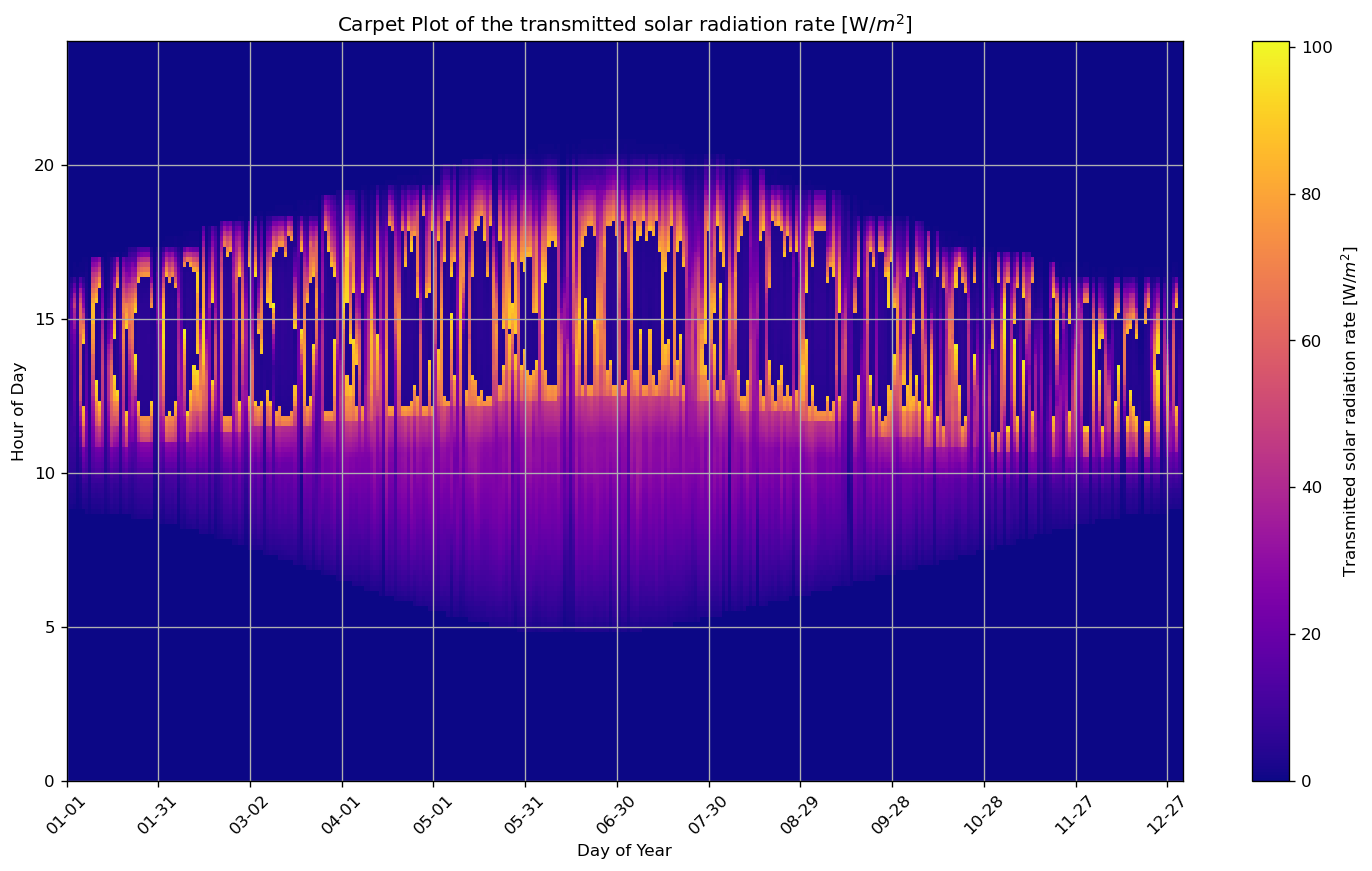

In [7]:
# Create a new DataFrame with the 'Surface Window Transmitted Solar Radiation Rate [W](TimeStep)' column and the existing datetime index
Aw = 19.2 #Area of the window is 19.2m^2
sol_tr_df = df[['FACADE:Surface Window Transmitted Solar Radiation Rate [W](TimeStep)']].div(Aw).copy()
sol_tr_df.index = df.index
sol_in_df = df[['FACADE:Surface Outside Face Incident Solar Radiation Rate per Area [W/m2](TimeStep)']].copy()
sol_in_df.index = df.index

num_days = 365
points_per_day = 144

sol_tr_matrix = sol_tr_df.values.reshape(num_days, points_per_day).T # Transpose the matrix
sol_in_matrix = sol_in_df.values.reshape(num_days, points_per_day).T # Transpose the matrix
#display(sol_tr_df[50:100])
# Create the carpet plot
plt.figure(figsize=(15, 8)) # Adjusted figure size for better readability

# Get the datetime index from surface_construction_df and drop NaT values
datetime_index = sol_tr_df.index.dropna()

# Create a list of hours for the y-axis
hours_of_day = np.linspace(0, 24, points_per_day)


# Use a monochromatic blue colormap and remove colorbar
plt.imshow(sol_tr_matrix, aspect='auto', cmap=matplotlib.colormaps['plasma'], origin='lower', # Changed cmap
           extent=[0, num_days, hours_of_day[0], hours_of_day[-1]]) # Adjust extent for days and hours

plt.title('Carpet Plot of the transmitted solar radiation rate [W/$m^2$]')
plt.xlabel('Day of Year') # Changed x-axis label back to 'Day of Year'
plt.ylabel('Hour of Day')
# plt.colorbar(label='Mapped FACADE:Surface Construction Index') # Removed colorbar

# Set x-axis ticks to show day and month
# Create a list of dates for the x-axis labels
dates_for_ticks = pd.date_range(start='1/1/2025', periods=num_days, freq='D')
plt.xticks(np.arange(0, num_days, step=30), [date.strftime('%m-%d') for date in dates_for_ticks[::30]], rotation=45) # Show ticks every 30 days

# Create custom legend
# Get the colormap and normalize the values for legend patches
cmap = matplotlib.colormaps['plasma']
norm = plt.Normalize(vmin=surf_constr_matrix.min(), vmax=surf_constr_matrix.max())

plt.colorbar(label='Transmitted solar radiation rate [W/$m^2$]')

plt.show()

## 5. Comfort assessment

We evaluate how often the zone operative temperature lies within a chosen comfort band, optionally during occupied hours only.


Comfort band: 20.0–26.0 °C
Occupied hours in band: 26194 / 52560 (49.8% of occupied hours)


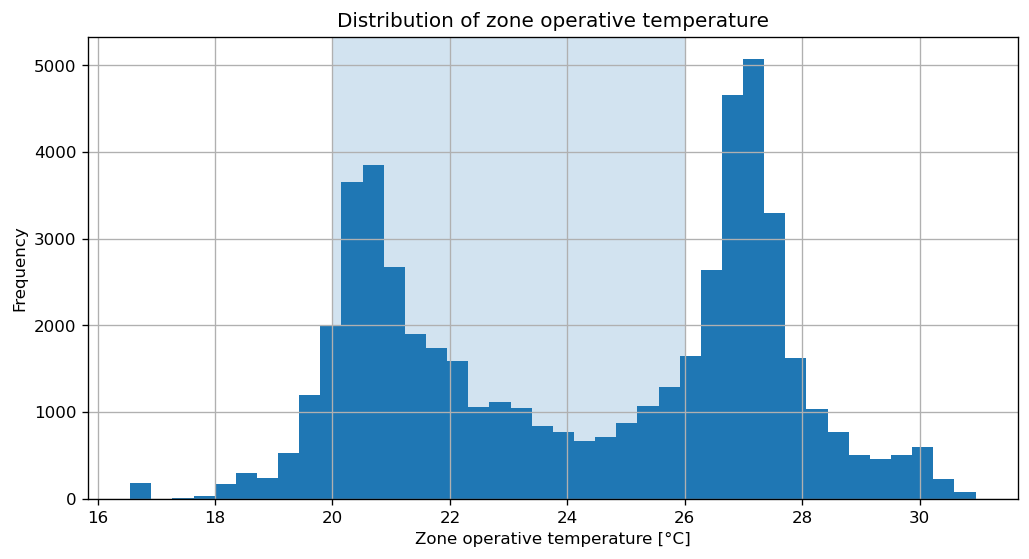

In [8]:
# Define a simple comfort band (can be refined)
t_min, t_max = 20.0, 26.0

if col_activity is not None:
    occupied = df[col_activity] > 0.1
else:
    occupied = pd.Series(True, index=df.index)

in_band = (df[col_t_zone_op] >= t_min) & (df[col_t_zone_op] <= t_max)
hours_total = occupied.sum()
hours_in_band = (in_band & occupied).sum()
share_in_band = hours_in_band / hours_total * 100 if hours_total > 0 else np.nan

print(f"Comfort band: {t_min:.1f}–{t_max:.1f} °C")
print(f"Occupied hours in band: {hours_in_band} / {hours_total} ({share_in_band:.1f}% of occupied hours)")

# Plot histogram of operative temperature
fig, ax = plt.subplots()
ax.hist(df[col_t_zone_op], bins=40)
ax.axvspan(t_min, t_max, alpha=0.2)
ax.set_xlabel('Zone operative temperature [°C]')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of zone operative temperature')
plt.show()


## 6. Monthly energy use breakdown

We aggregate energy uses by month and visualize heating, cooling, fans, and lighting.


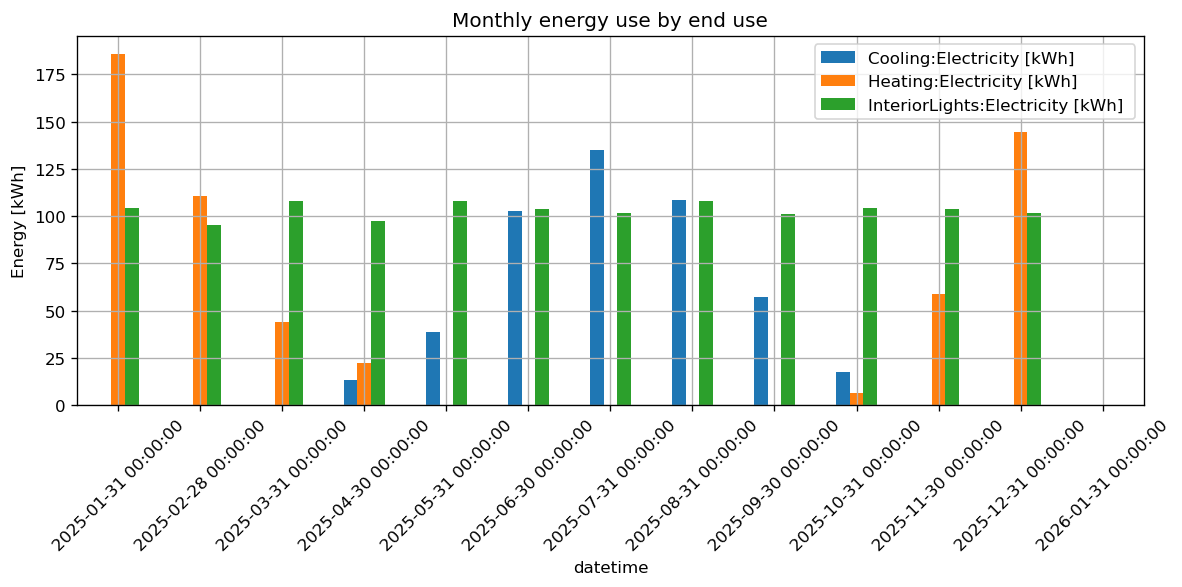

Annual energy by end use [kWh]:
Cooling:Electricity [kWh]             473.371294
Heating:Electricity [kWh]             572.484052
InteriorLights:Electricity [kWh]     1238.477791
dtype: float64


In [9]:
energy_cols = [
    'Cooling:Electricity [kWh]',
    'Heating:Electricity [kWh]',
    'InteriorLights:Electricity [kWh] '
]

energy_ts = df[energy_cols].copy()
monthly_energy = energy_ts.resample('ME').sum()

monthly_energy.plot(kind='bar', stacked=False)
plt.ylabel('Energy [kWh]')
plt.title('Monthly energy use by end use')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Annual energy by end use [kWh]:")
print(monthly_energy.sum())


## 7. Façade blind state analysis

We investigate how often each façade construction (blind state) is used and how it relates to solar conditions and cooling demand.


Façade states (index → label):
  6 → Open
  7 → Closed


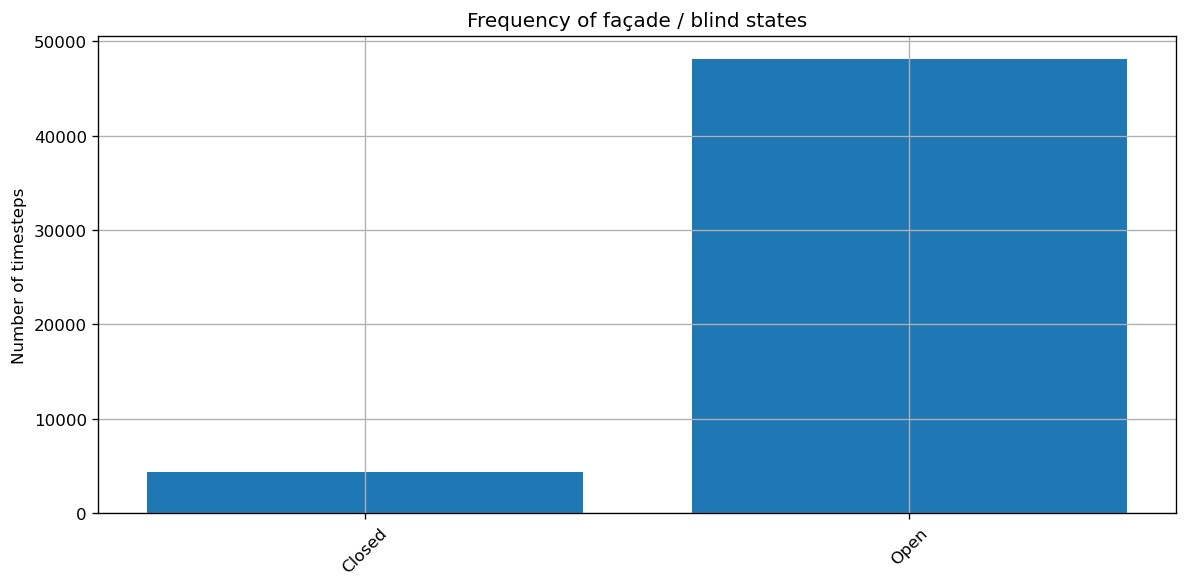

In [10]:
# Analyze unique façade / blind states

facade_states = df[col_facade_idx].dropna().unique()
facade_states_sorted = np.sort(facade_states)

# Build mapping depending on shading_system_type
if shading_system_type == 'venetian':
    # Use the same mapping logic as in your base notebook
    # (adjust labels here if you want different angles/texts)
    state_map = {
        15: 'No blinds',
        14: '85°',
        13: '60°',
        12: '45°',
        11: '20°',
        10: '0°'
    }

elif shading_system_type == 'external_classic':
    # External rolling blind: 6 = open, 7 = closed
    state_map = {
        6: 'Open',
        7: 'Closed'
    }

elif shading_system_type == 'internal_metallic':
    # Internal metallic blind: 10 = open, 11 = closed
    state_map = {
        10: 'Open',
        11: 'Closed'
    }

else:
    # Fallback: generic labels, in case shading_system_type is something else
    state_map = {val: f"State {val}" for val in facade_states_sorted}

# Apply mapping
df['facade_state_label'] = df[col_facade_idx].map(state_map)

print("Façade states (index → label):")
for k in sorted(state_map.keys()):
    print(f"  {k} → {state_map[k]}")

# Frequency of each state (by label)
state_counts = df['facade_state_label'].value_counts().sort_index()

fig, ax = plt.subplots()
ax.bar(state_counts.index, state_counts.values)
ax.set_ylabel('Number of timesteps')
ax.set_title('Frequency of façade / blind states')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


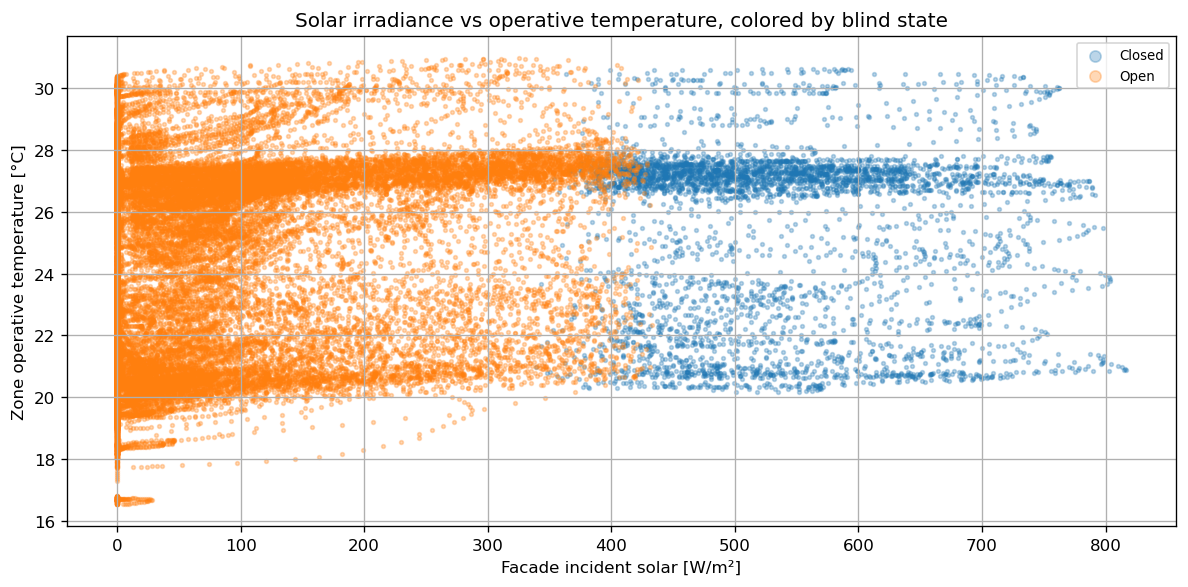

In [11]:
# Relationship between incident solar and façade / blind state

fig, ax = plt.subplots()

# We rely on the 'facade_state_label' created in the previous cell
unique_labels = sorted(df['facade_state_label'].dropna().unique())

for state_label in unique_labels:
    mask = df['facade_state_label'] == state_label
    ax.scatter(
        df.loc[mask, col_solar_facade],
        df.loc[mask, col_t_zone_op],
        s=5,
        alpha=0.3,
        label=state_label
    )

ax.set_xlabel('Facade incident solar [W/m²]')
ax.set_ylabel('Zone operative temperature [°C]')
ax.set_title('Solar irradiance vs operative temperature, colored by blind state')
ax.legend(markerscale=3, fontsize=8)
plt.tight_layout()
plt.show()

